In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

from market_timing import MarketTiming
from qdb import QdbApi
q = QdbApi()

成功连接数据库：user=read_only)
连接Arctic失败：user=None)


## 指标：北向资金净买入

$$
X_t:= NorthCap(t_i)
$$

使用过去50个交易日作为滑动窗口进行Z-score标准化，得到最终输入信号$fcst$
$$
fcst = \{fcst_t,\ t\in T\}:= \{f(X_t),\ t\in T\}
= \left\{ \frac{X_t - \bar{x}_t}{\sigma_{t}}, t\in T \right\}
$$
$\bar{x}_t$和$\sigma_{t}$为过去50个交易日$[t-49, t]$的均值和标准差

成功连接数据库：user=read_only)
连接Arctic失败：user=None)
更新了缓存数据：index_list
对股指：沪深300指数进行择时信号的评估与回测，
从2019-01-02到2022-05-31的数据用于外推效果验证
对择时信号进行滑动窗口标准化，winndow_size = 50
得到预测序列fcst
count    828.000000
mean       0.034756
std        1.024071
min       -4.699969
25%       -0.559245
50%        0.028999
75%        0.608809
max        4.745678
Name: fcst, dtype: float64


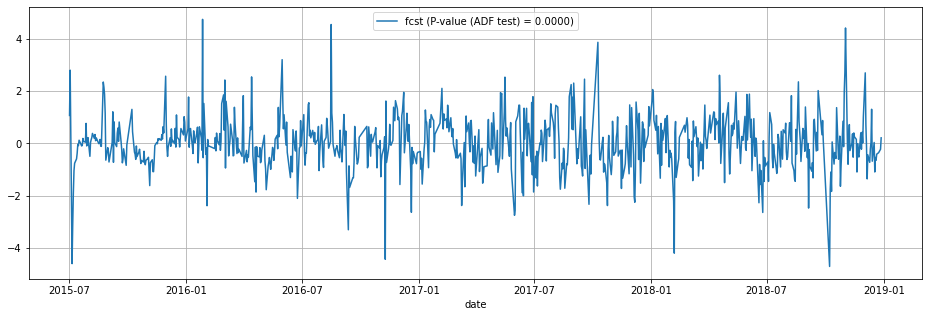

In [5]:
start_date = mt_model.start_date
end_date = mt_model.end_date

north_cap_sgn = mt_model.get_macro_data(macro_ids=["north_cap"], 
                                        start_date=start_date, 
                                        end_date=end_date).set_index("data_date")["value_"]

mt_model.signal(north_cap_sgn)

## 内积评估
定义
$$ret(t+h) = \left.\left (\frac{Close(t+h)}{Open(t+1)} - 1\right )\right/ h $$
表示未来$h$天股指的平均日涨跌幅和
$$ret(t+h_1, t+h_2) = \left.\left(\frac{Close(t+h_2)}{Open(t+h_1)} - 1\right)\right/ (h_2-h_1+1)$$
表示从未来$h_1$天到未来$h_2$天股指的涨跌幅。再使用不同的时间期限分别计算内积
$$
fcst^T \cdot [ ret_{1}, ret_{5}, ret_{10}, ret_{21}, ret_{63} ]
$$
和
$$
fcst^T \cdot [ ret_{1}, ret_{2, 5}, ret_{6, 10}, ret_{11, 21}, ret_{22, 63} ]
$$
生成累积的内积序列，分别作图比较

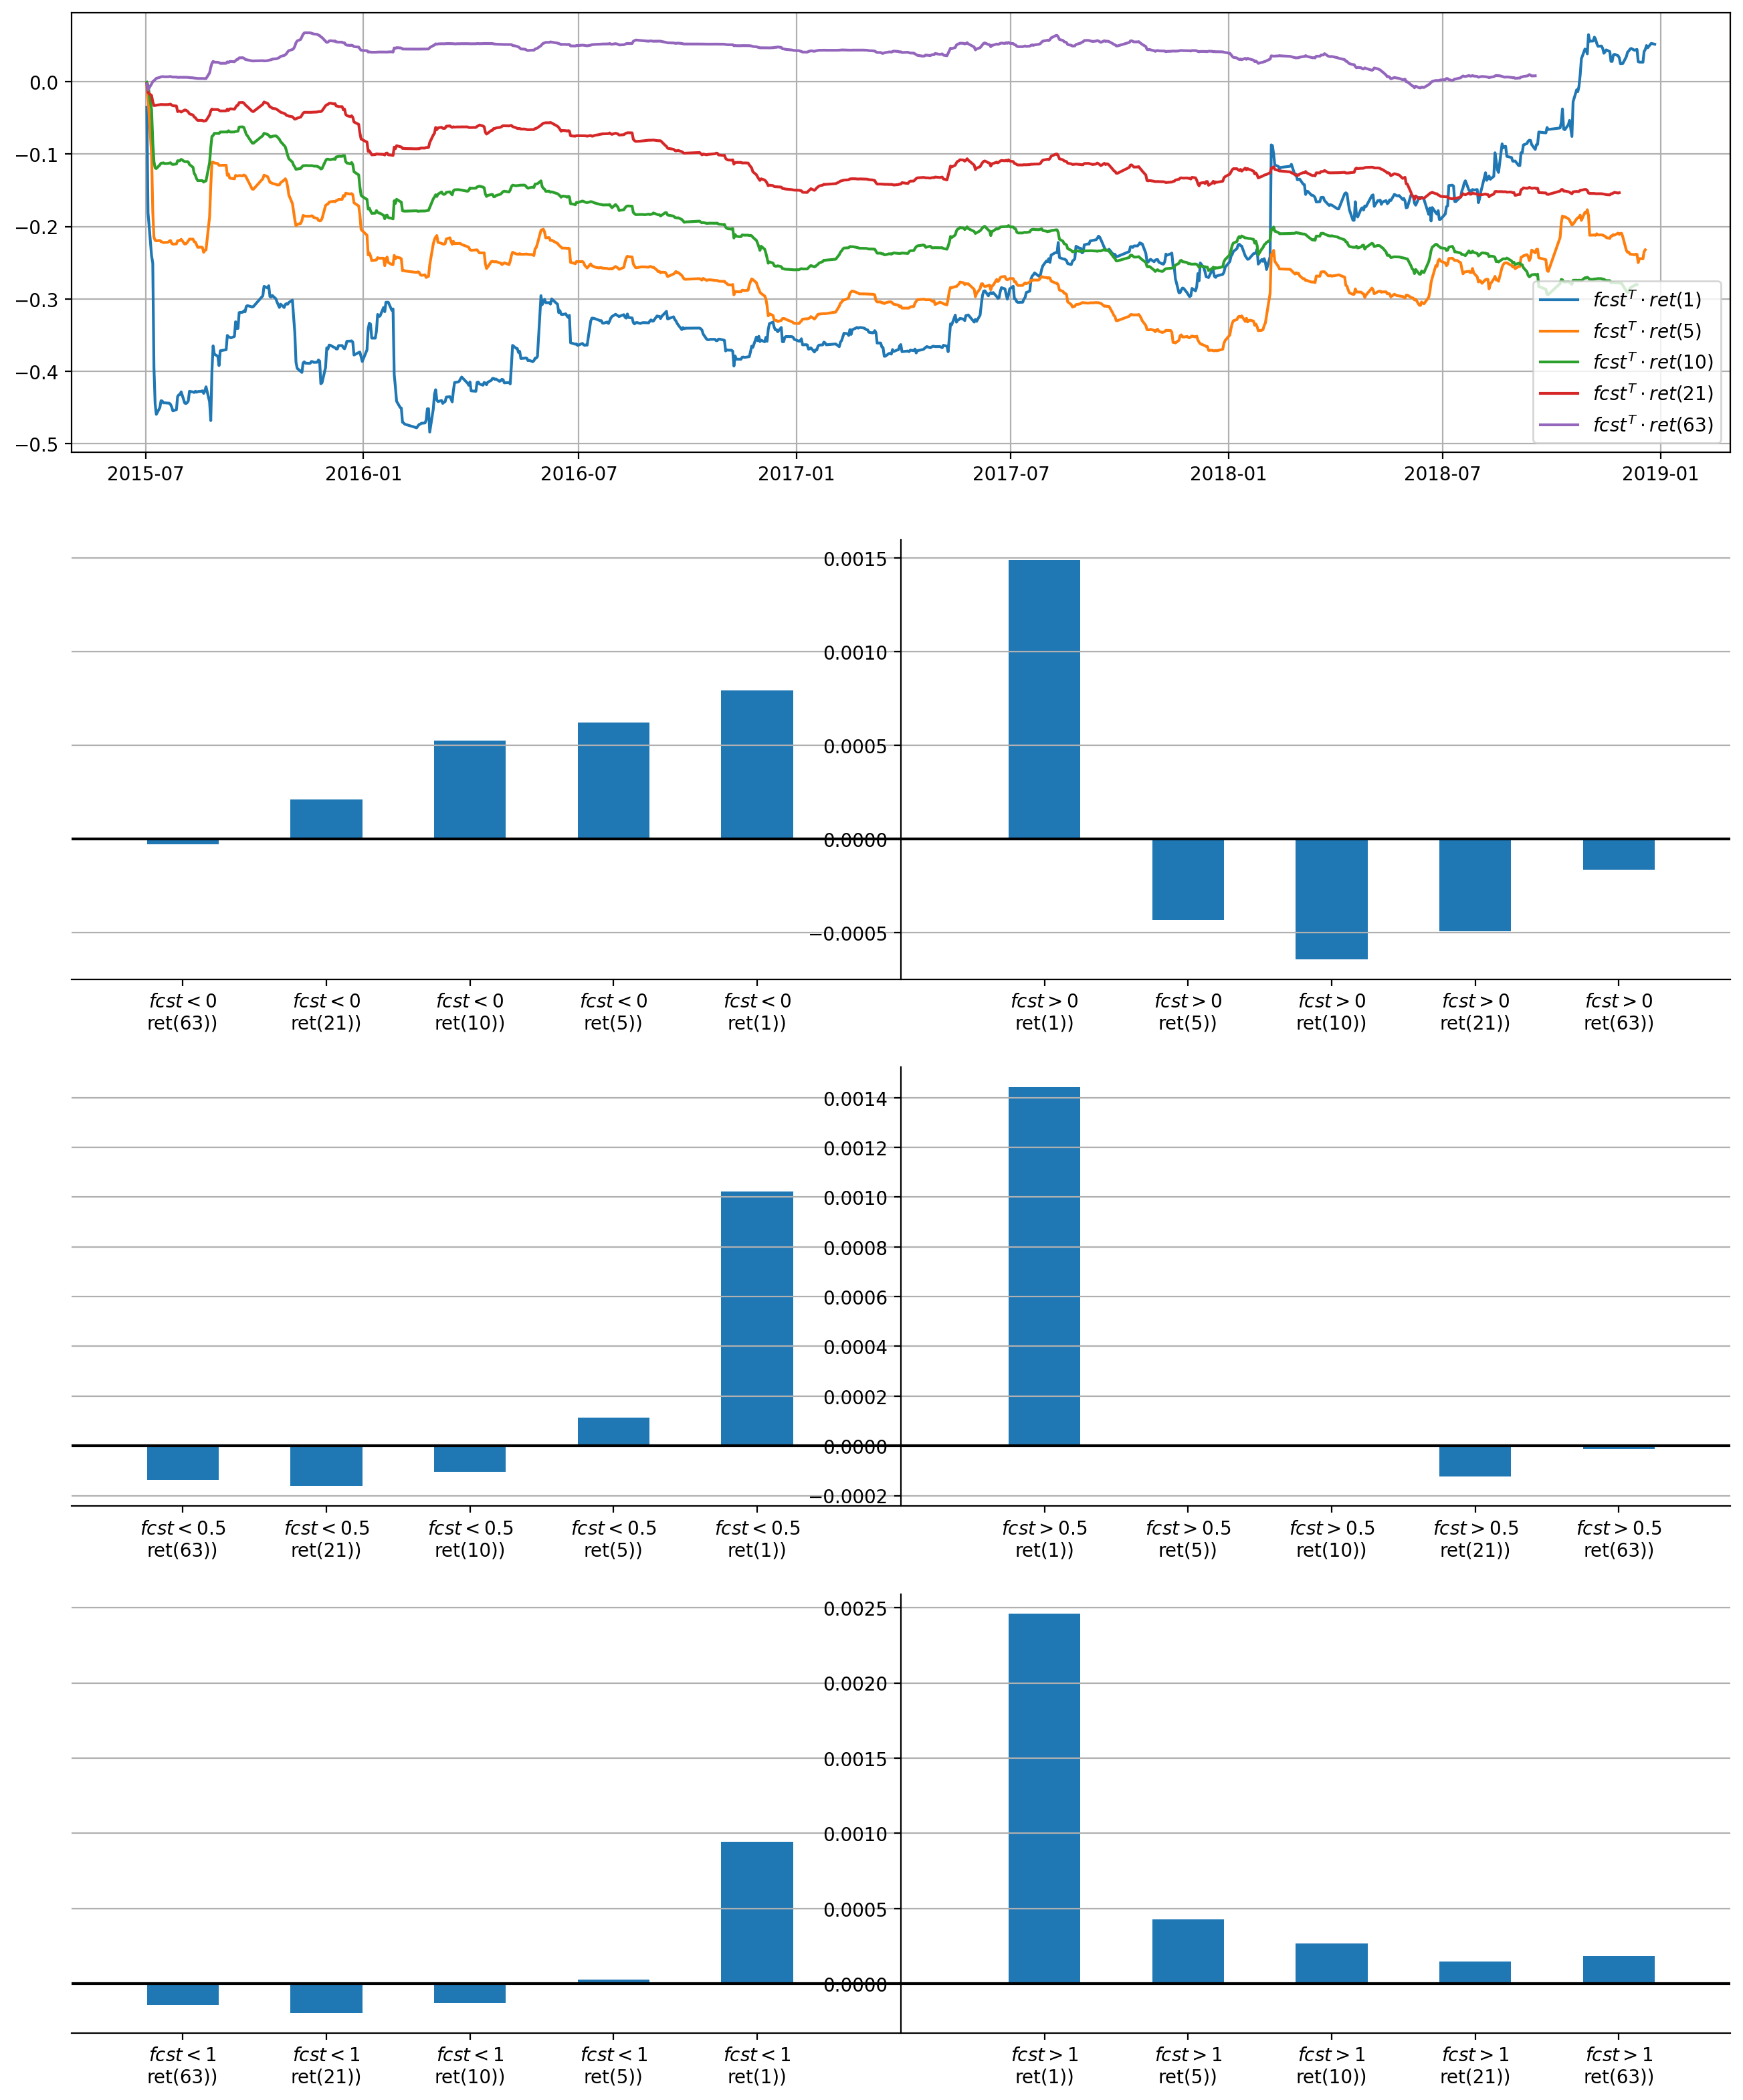

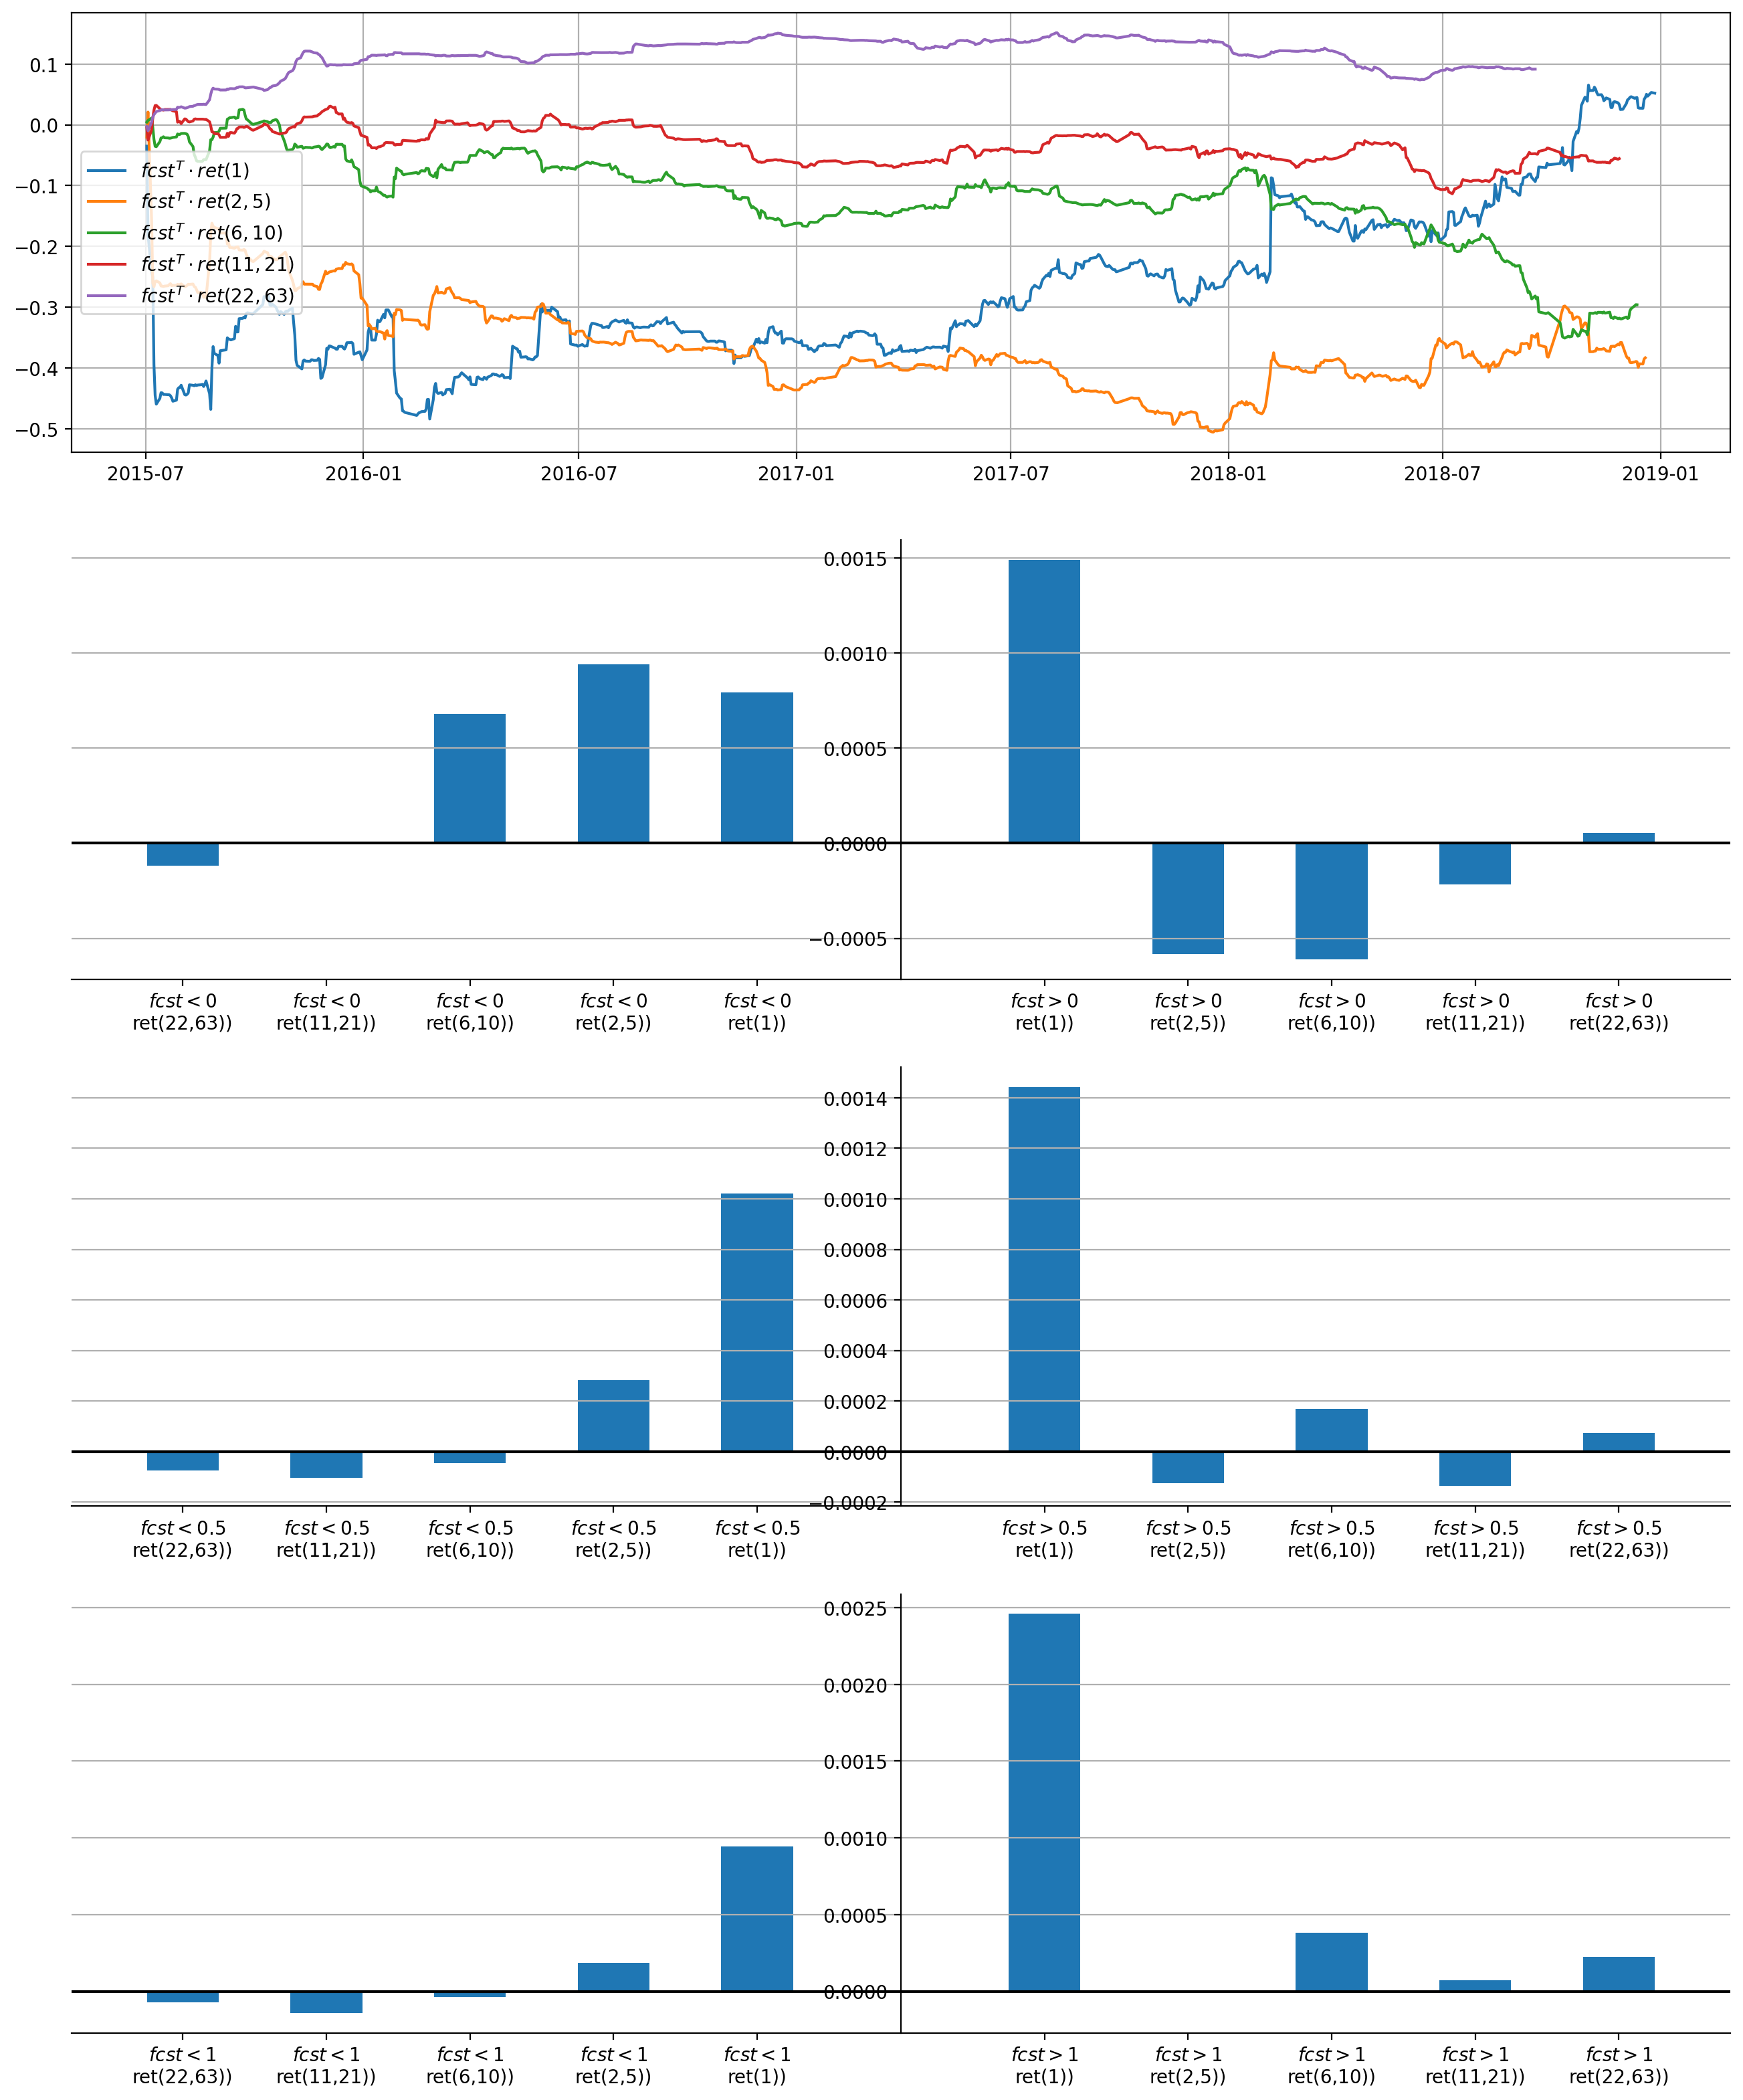

In [6]:
mt_model.dot_product_analysis()

## 与主要因子相关性

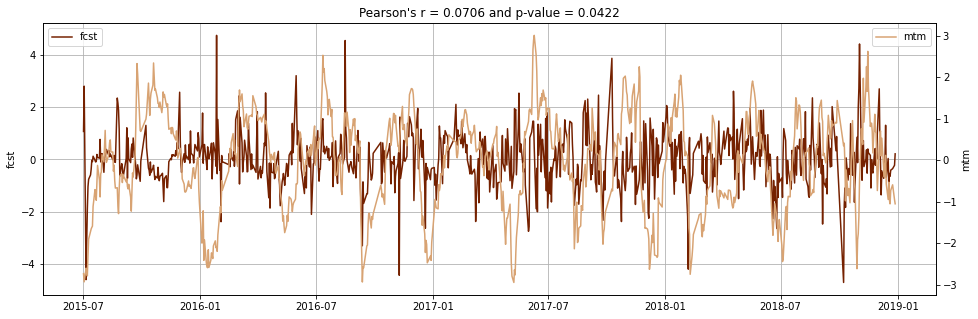

In [7]:
mt_model.corr_analysis()

## 回测


- 做多：$t$日触发$fcst_{t} > 1$时，对$t+1$日的股指进行做多操作（$pos_{t+1} = 1$），$t+2$日恢复平仓（$pos_{t+2} = 0$）
- 做空：$t$日触发$fcst_{t} < 1$时，对从$t+22$日到$t+63$日的股指开始进行做空操作（$pos = -1$），$t+64$日恢复平仓
- 做空操作期间，如果触发做多信号，则立即转为做多

股指隔夜涨跌幅
$$overnight\_ret_t = \frac{Open_t}{Close_{t-1}} - 1$$
股指白天涨跌幅
$$daytime\_ret_t = \frac{Close_t}{Open_{t}} - 1$$
因此$t$日的策略收益$stgy\_ret_t$由隔夜收益和白天收益两部分组成
$$stgy\_ret_t = (1 + pos_{t-1} \cdot overnight\_ret_t) (1 + pos_{t} \cdot daytime\_ret_t) - 1$$

## 业绩评估

,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,-0.094097,-0.111002,0.252487,-0.471695,-0.329004,-0.286005
stgy_long,0.073774,0.097442,0.088114,0.55353,-0.067188,1.098027
stgy,0.192752,0.226626,0.169538,0.989466,-0.138032,1.396431


,总胜率,看多胜率,看空胜率
做多做空,0.524366,0.642857,0.491272
只做多,0.642857,0.642857,NaN


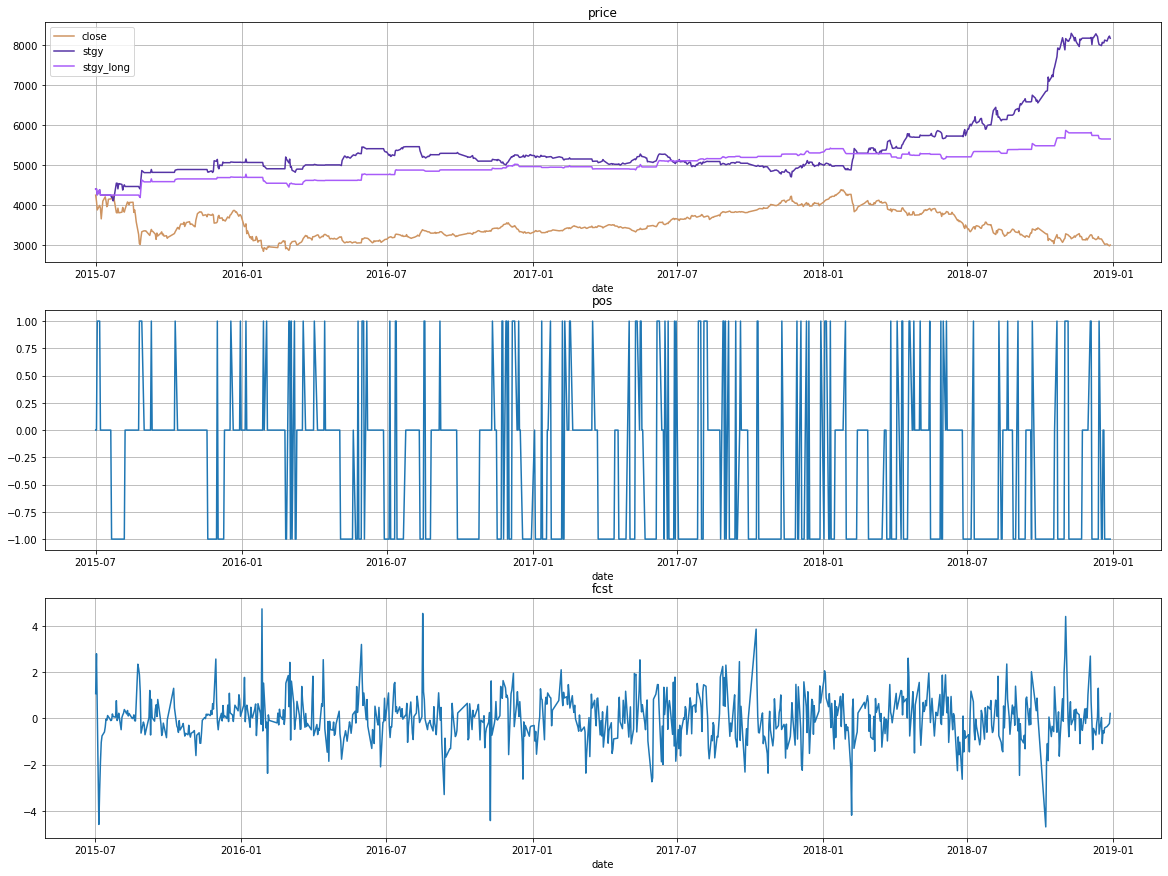

In [8]:
mt_model.backtest(
    long_threshold=1, long_start=1, long_period=1,
    short_threshold=-1, short_start=11, short_period=10,
    mode='history'
)

,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,0.098522,0.137998,0.215318,0.341457,-0.348433,0.282757
stgy_long,0.061312,0.055242,0.076595,0.47408,-0.110641,0.554154
stgy,0.133832,0.14772,0.174289,0.624434,-0.150799,0.887487


,总胜率,看多胜率,看空胜率
做多做空,0.512476,0.554455,0.502381
只做多,0.554455,0.554455,NaN


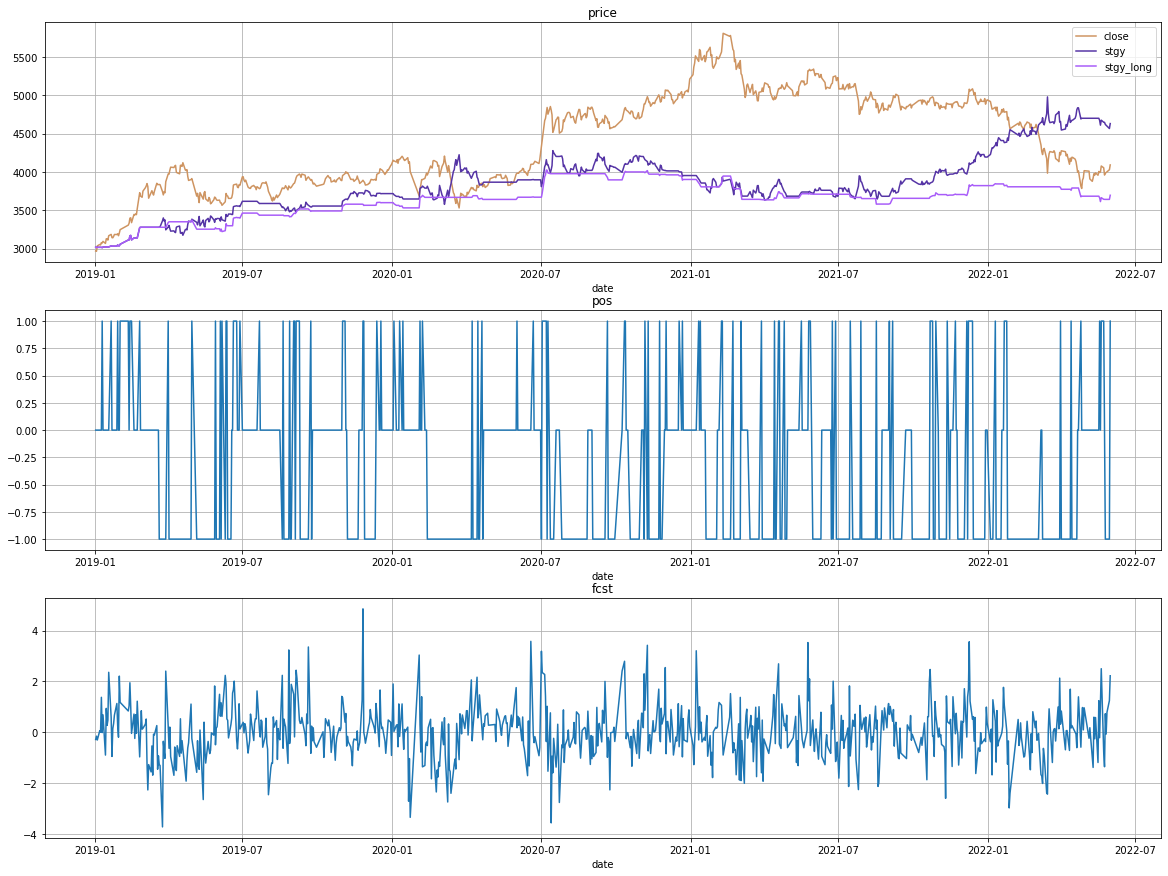

In [9]:
mt_model.backtest(
    long_threshold=1, long_start=1, long_period=1,
    short_threshold=-1, short_start=11, short_period=10,
    mode='test'
)

,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,-0.005578,0.010675,0.235018,-0.13011,-0.348433,-0.01601
stgy_long,0.067463,0.076673,0.082638,0.513845,-0.110641,0.609748
stgy,0.156643,0.177026,0.172639,0.762532,-0.150799,1.038752


,总胜率,看多胜率,看空胜率
做多做空,0.517703,0.600939,0.496394
只做多,0.600939,0.600939,NaN


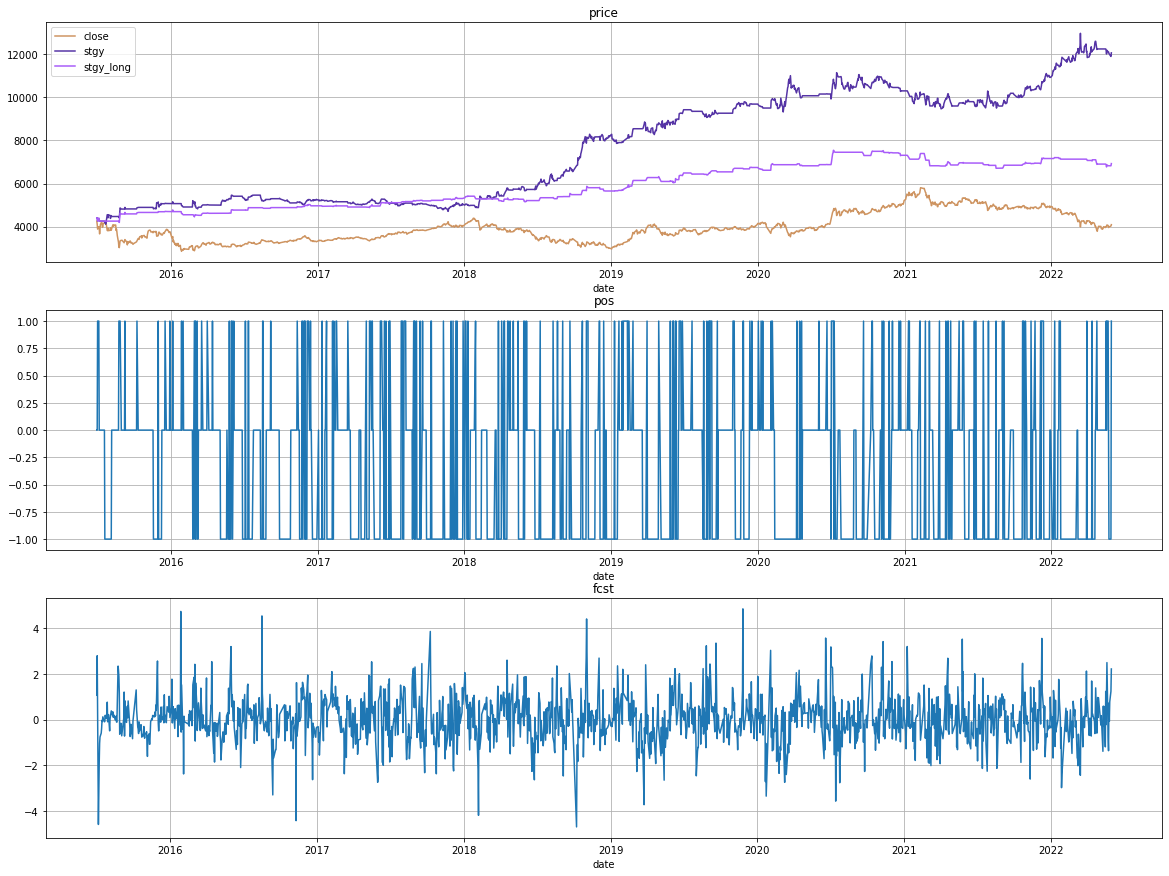

In [10]:
mt_model.backtest(
    long_threshold=1, long_start=1, long_period=1,
    short_threshold=-1, short_start=11, short_period=10,
    mode='all'
)

In [ ]:
盈亏比
盈亏分布曲线
收益率周月度效益分布（+节假日前后）
换手率
主要因子相关性（动量因子-过去20）
指数 线性回归 alpha beta


两套策略 
 - 每天调仓
- 